# MODIS Water XGBOOST Hyperparameter Tuning - Multi-GPU

Version: 0.3.0

Date modified: 04.13.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

import optuna

import dask
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [25]:
cluster = LocalCUDACluster()
client = Client(cluster)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [26]:
cluster

In [27]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:35833/status,
Dashboard: http://127.0.0.1:35833/status,Workers: 4
Total threads: 4,Total memory: 754.33 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32961,Workers: 4
Dashboard: http://127.0.0.1:35833/status,Total threads: 4
Started: Just now,Total memory: 754.33 GiB
Comm: tcp://10.100.38.13:36513,Total threads: 1
Dashboard: http://10.100.38.13:37271/status,Memory: 188.58 GiB
Nanny: tcp://127.0.0.1:44707,


In [2]:
FIGURE_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/feature_eng'

qaMaskPath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/adapt/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
TILE = 'Golden'
MODEL = 'xgboost'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = ['b01_ndwi1',
 'b03_sur_refl_b01_1',
 'b03_ndwi2',
 'b01_sur_refl_b06_1',
 'b07_ndwi1',
 'b04_ndwi1',
 'b07_ndwi2',
 'b04_sur_refl_b02_1',
 'b06_ndwi2',
 'ndwi2',
 'b02_sur_refl_b06_1',
 'ndwi1_ndwi2',
 'b01_ndvi',
 'ndwi1_ndvi',
 'b02_ndwi1',
 'ndvi_sur_refl_b06_1',
 'b06_sur_refl_b03_1',
 'ndwi2_sur_refl_b07_1',
 'b06_sur_refl_b04_1',
 'ndwi1_sur_refl_b04_1',
 'ndwi1_sur_refl_b03_1',
 'ndvi_sur_refl_b01_1',
 'ndwi2_ndwi1',
 'ndvi_sur_refl_b07_1',
 'b07_sur_refl_b03_1',
 'b02_sur_refl_b07_1',
 'ndwi2_sur_refl_b02_1',
 'ndwi1_sur_refl_b01_1',
 'b07_sur_refl_b02_1',
 'ndwi2_sur_refl_b01_1',
 'ndwi2_sur_refl_b03_1',
 'b04_sur_refl_b01_1',
 'ndwi2_sur_refl_b06_1',
 'ndwi2_sur_refl_b04_1',
 'ndwi1_sur_refl_b06_1',
 'ndwi1_sur_refl_b07_1',
 'ndvi_sur_refl_b04_1',
 'b04_ndwi2',
 'b03_sur_refl_b02_1',
 'ndvi_sur_refl_b03_1',
 'ndwi2_ndvi',
 'b01_ndwi2',
 'sur_refl_b05_1',
 'b01_sur_refl_b04_1',
 'sur_refl_b04_1',
 'b07_sur_refl_b04_1',
 'b07_sur_refl_b06_1',
 'b02_sur_refl_b03_1',
 'b02_ndwi2',
 'b07_sur_refl_b01_1',
 'ndvi_ndwi1',
 'ndwi1',
 'b03_ndvi',
 'b06_ndvi',
 'ndvi_sur_refl_b02_1',
 'b06_sur_refl_b02_1',
 'b06_ndwi1',
 'ndvi_ndwi2',
 'b03_ndwi1',
 'b06_sur_refl_b01_1',
 'b02_sur_refl_b01_1',
 'ndwi1_sur_refl_b02_1',
 'b03_sur_refl_b07_1',
 'b01_sur_refl_b02_1',
 'b02_sur_refl_b04_1']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)

#v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
#           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
#           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b06_1', 'sur_refl_b07_1',
           'ndvi','ndwi1','ndwi2']

index_names = {'sur_refl_b01_1': 0,
               'sur_refl_b02_1': 1,
               'sur_refl_b03_1': 2,
               'sur_refl_b04_1': 3,
               'sur_refl_b05_1': 4,
               'sur_refl_b06_1': 5,
               'sur_refl_b07_1': 6,
               'ndvi': 7,
               'ndwi1': 8,
               'ndwi2': 9,}

In [3]:
colsToDrop

['b01_ndwi1',
 'b03_sur_refl_b01_1',
 'b03_ndwi2',
 'b01_sur_refl_b06_1',
 'b07_ndwi1',
 'b04_ndwi1',
 'b07_ndwi2',
 'b04_sur_refl_b02_1',
 'b06_ndwi2',
 'ndwi2',
 'b02_sur_refl_b06_1',
 'ndwi1_ndwi2',
 'b01_ndvi',
 'ndwi1_ndvi',
 'b02_ndwi1',
 'ndvi_sur_refl_b06_1',
 'b06_sur_refl_b03_1',
 'ndwi2_sur_refl_b07_1',
 'b06_sur_refl_b04_1',
 'ndwi1_sur_refl_b04_1',
 'ndwi1_sur_refl_b03_1',
 'ndvi_sur_refl_b01_1',
 'ndwi2_ndwi1',
 'ndvi_sur_refl_b07_1',
 'b07_sur_refl_b03_1',
 'b02_sur_refl_b07_1',
 'ndwi2_sur_refl_b02_1',
 'ndwi1_sur_refl_b01_1',
 'b07_sur_refl_b02_1',
 'ndwi2_sur_refl_b01_1',
 'ndwi2_sur_refl_b03_1',
 'b04_sur_refl_b01_1',
 'ndwi2_sur_refl_b06_1',
 'ndwi2_sur_refl_b04_1',
 'ndwi1_sur_refl_b06_1',
 'ndwi1_sur_refl_b07_1',
 'ndvi_sur_refl_b04_1',
 'b04_ndwi2',
 'b03_sur_refl_b02_1',
 'ndvi_sur_refl_b03_1',
 'ndwi2_ndvi',
 'b01_ndwi2',
 'sur_refl_b05_1',
 'b01_sur_refl_b04_1',
 'sur_refl_b04_1',
 'b07_sur_refl_b04_1',
 'b07_sur_refl_b06_1',
 'b02_sur_refl_b03_1',
 'b02_ndwi2

In [4]:
colsToDropTraining

['b01_ndwi1',
 'b03_sur_refl_b01_1',
 'b03_ndwi2',
 'b01_sur_refl_b06_1',
 'b07_ndwi1',
 'b04_ndwi1',
 'b07_ndwi2',
 'b04_sur_refl_b02_1',
 'b06_ndwi2',
 'ndwi2',
 'b02_sur_refl_b06_1',
 'ndwi1_ndwi2',
 'b01_ndvi',
 'ndwi1_ndvi',
 'b02_ndwi1',
 'ndvi_sur_refl_b06_1',
 'b06_sur_refl_b03_1',
 'ndwi2_sur_refl_b07_1',
 'b06_sur_refl_b04_1',
 'ndwi1_sur_refl_b04_1',
 'ndwi1_sur_refl_b03_1',
 'ndvi_sur_refl_b01_1',
 'ndwi2_ndwi1',
 'ndvi_sur_refl_b07_1',
 'b07_sur_refl_b03_1',
 'b02_sur_refl_b07_1',
 'ndwi2_sur_refl_b02_1',
 'ndwi1_sur_refl_b01_1',
 'b07_sur_refl_b02_1',
 'ndwi2_sur_refl_b01_1',
 'ndwi2_sur_refl_b03_1',
 'b04_sur_refl_b01_1',
 'ndwi2_sur_refl_b06_1',
 'ndwi2_sur_refl_b04_1',
 'ndwi1_sur_refl_b06_1',
 'ndwi1_sur_refl_b07_1',
 'ndvi_sur_refl_b04_1',
 'b04_ndwi2',
 'b03_sur_refl_b02_1',
 'ndvi_sur_refl_b03_1',
 'ndwi2_ndvi',
 'b01_ndwi2',
 'sur_refl_b05_1',
 'b01_sur_refl_b04_1',
 'sur_refl_b04_1',
 'b07_sur_refl_b04_1',
 'b07_sur_refl_b06_1',
 'b02_sur_refl_b03_1',
 'b02_ndwi2

In [5]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [6]:
indices_to_make = []
for name in v_names:
    for name_2 in [v_name for v_name in v_names]:
        print('Index: {} x {}'.format(name, name_2))
        indices_to_make.append((name, name_2))
for idx in indices_to_make:
    if idx[0] in idx[1]:
        print(idx)
        indices_to_make.remove(idx)

add_names = {}
band_combo = {}
for i, idx in enumerate(indices_to_make):
    index = i + len(index_names.keys())
    add_names['{}_{}'.format(idx[0].split('refl_')[-1].split('_')[0], idx[1])] = index
    band_combo['{}_{}'.format(idx[0].split('refl_')[-1].split('_')[0], idx[1])] = indices_to_make[i]
index_names.update(add_names)

Index: sur_refl_b01_1 x sur_refl_b01_1
Index: sur_refl_b01_1 x sur_refl_b02_1
Index: sur_refl_b01_1 x sur_refl_b03_1
Index: sur_refl_b01_1 x sur_refl_b04_1
Index: sur_refl_b01_1 x sur_refl_b06_1
Index: sur_refl_b01_1 x sur_refl_b07_1
Index: sur_refl_b01_1 x ndvi
Index: sur_refl_b01_1 x ndwi1
Index: sur_refl_b01_1 x ndwi2
Index: sur_refl_b02_1 x sur_refl_b01_1
Index: sur_refl_b02_1 x sur_refl_b02_1
Index: sur_refl_b02_1 x sur_refl_b03_1
Index: sur_refl_b02_1 x sur_refl_b04_1
Index: sur_refl_b02_1 x sur_refl_b06_1
Index: sur_refl_b02_1 x sur_refl_b07_1
Index: sur_refl_b02_1 x ndvi
Index: sur_refl_b02_1 x ndwi1
Index: sur_refl_b02_1 x ndwi2
Index: sur_refl_b03_1 x sur_refl_b01_1
Index: sur_refl_b03_1 x sur_refl_b02_1
Index: sur_refl_b03_1 x sur_refl_b03_1
Index: sur_refl_b03_1 x sur_refl_b04_1
Index: sur_refl_b03_1 x sur_refl_b06_1
Index: sur_refl_b03_1 x sur_refl_b07_1
Index: sur_refl_b03_1 x ndvi
Index: sur_refl_b03_1 x ndwi1
Index: sur_refl_b03_1 x ndwi2
Index: sur_refl_b04_1 x sur_ref

In [7]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = sorted([fv for fv in glob.glob(glob_string)])
data_path = data_paths[1]
pprint(data_paths)
print(data_path)

['/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/feature_eng/MOD09_Golden_Masked_1007000_4_2_1.parquet.gzip',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/feature_eng/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']
/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/feature_eng/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip


In [8]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [9]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
b01_sur_refl_b03_1
b01_sur_refl_b07_1
b02_ndvi
b03_sur_refl_b04_1
b03_sur_refl_b06_1
b04_sur_refl_b03_1
b04_sur_refl_b06_1
b04_sur_refl_b07_1
b04_ndvi
b06_sur_refl_b07_1
b07_ndvi


In [10]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,603816.0,1410.259760,2214.392781,-100.0,147.0,722.0,1419.0,16000.0
sur_refl_b02_1,603816.0,2008.256557,2040.852819,-100.0,137.0,1979.0,2634.0,16000.0
sur_refl_b03_1,603816.0,1138.171938,2234.032231,-100.0,204.0,367.0,695.0,13193.0
sur_refl_b06_1,603816.0,1575.513875,1354.277623,-100.0,88.0,1528.0,2650.0,11197.0
sur_refl_b07_1,603816.0,444.167076,4322.842045,-28672.0,46.0,722.0,1746.0,7346.0
ndvi,603816.0,-303.727901,6829.488951,-32727.0,-3446.0,1255.0,4201.0,32679.0
b01_sur_refl_b03_1,603816.0,415.662347,4464.803703,-32727.0,-1428.0,2285.0,3662.0,32762.0
b01_sur_refl_b07_1,603816.0,256.885546,5039.538082,-32727.0,-3273.0,-1570.5,3584.0,32762.0
b02_ndvi,603816.0,-2846.170451,8345.589418,-32768.0,-9994.0,-3938.0,589.0,32767.0
b03_sur_refl_b04_1,603816.0,-1472.824501,2359.248731,-32727.0,-2925.0,-2234.0,48.0,32500.0


In [11]:
X_train.sample(5)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,b01_sur_refl_b03_1,b01_sur_refl_b07_1,b02_ndvi,b03_sur_refl_b04_1,b03_sur_refl_b06_1,b04_sur_refl_b03_1,b04_sur_refl_b06_1,b04_sur_refl_b07_1,b04_ndvi,b06_sur_refl_b07_1,b07_ndvi
686409,37,-4,209,35,38,-12424,-6991,-133,-9993,2294,7131,-2294,5783,5502,-10213,-410,-10061
278050,779,2383,374,2781,1608,5072,3512,-3472,-3607,-2869,-7629,2869,-6093,-4086,-7651,2672,-5186
301351,26,3,146,70,19,-7931,-6976,1555,-10007,2425,3518,-2425,1194,6481,-10226,5730,-10048
647849,623,1531,284,2273,1441,4215,3737,-3963,-4671,-3131,-7778,3131,-6143,-4526,-7717,2240,-4904
92907,62,30,215,96,88,-3478,-5523,-1733,-10174,2181,3826,-2181,1794,2212,-10826,434,-10519


In [12]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [13]:
output_interesting_idx(X_train, 'ndvi', 32000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,b01_sur_refl_b03_1,b01_sur_refl_b07_1,b02_ndvi,b03_sur_refl_b04_1,b03_sur_refl_b06_1,b04_sur_refl_b03_1,b04_sur_refl_b06_1,b04_sur_refl_b07_1,b04_ndvi,b06_sur_refl_b07_1,b07_ndvi
198752,15,-8,112,9,43,32679,-7637,-4827,-9995,467,8512,-467,8378,4068,-10062,-6538,-10026
896738,15,-8,113,17,40,32679,-7656,-4545,-9995,710,7384,-710,7043,4202,-10059,-4035,-10024
388901,12,-11,132,73,54,32144,-8333,-6363,-9999,2054,2878,-2054,875,2340,-10007,1496,-10004
462912,12,-11,-27,42,-28672,32144,-26000,-10008,-9999,-13506,19536,13506,6233,-10127,-10015,-10029,-7783
674354,15,-8,134,77,64,32679,-7986,-6202,-9995,2181,2701,-2181,552,1466,-10052,921,-10039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412975,23,-26,225,37,20,32261,-8145,697,-10003,2931,7175,-2931,5375,7202,-9984,2982,-9997
724327,15,-8,168,99,87,32679,-8360,-7058,-9995,2262,2584,-2262,341,984,-10064,645,-10053
742328,15,-8,120,33,-28672,32679,-7777,-10010,-9995,762,5686,-762,5147,-10072,-10062,-10023,-680
577603,13,-7,113,56,40,32203,-7936,-5094,-9995,414,3372,-414,3000,4444,-10062,1666,-10024


## XGBOOST

Choose which combination of hyperparameters to train:

- n_estimators: Number of learners for the xgboost to fit.
- booster: Which booster to use
- lamda: L2 regularization rate
- alpha: L1 regularization rate
- subsample: sampling ration for training data
- colsample_bytree: sampling according to each tree
- max_depth: maximum depth of the tree, signifies complexity
- min_child_weight: minimum child weight, the larger the term, the more complex
- gamme: how selective the algorithm is

In [36]:
from cuml.dask.common import utils as dask_utils    

In [37]:
X_train = dask.dataframe.from_pandas(X_train, npartitions=4)
X_val = dask.dataframe.from_pandas(X_val, npartitions=4)
y_train = dask.dataframe.from_pandas(y_train, npartitions=4)
y_val = dask.dataframe.from_pandas(y_val, npartitions=4)
X_test = dask.dataframe.from_pandas(X_test, npartitions=4)
y_test = dask.dataframe.from_pandas(y_test, npartitions=4)

In [38]:
workers = client.has_what().keys()
workers

dict_keys(['tcp://10.100.38.13:36199', 'tcp://10.100.38.13:36513', 'tcp://10.100.38.13:37355', 'tcp://10.100.38.13:45319'])

In [39]:
X_train, y_train = dask_utils.persist_across_workers(client, [X_train, y_train], workers=workers)
X_val, y_val = dask_utils.persist_across_workers(client, [X_val, y_val], workers=workers)
X_test, y_test = dask_utils.persist_across_workers(client, [X_test, y_test], workers=workers)

In [40]:
def objective(trial):
    hyperparameters = {
        "verbosity": 0,
        #"learning_rate": 0.001,
        #"objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "gpu_hist",
        #"booster":"dart",
        #"rate_drop":0.9,
        #"gpu_id": 0,
        "n_jobs": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200, 250, 300, 500, 750]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.1, 0.3),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.3),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 3, 15, step=1), 
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight":  trial.suggest_int("min_child_weight", 2, 5), 
        "eta":  trial.suggest_float("eta", 1e-8, 1.0, log=True), 
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 0.5, log=True), 
        "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    classifier = xgb.dask.DaskXGBClassifier(**hyperparameters)
    classifier.client = client
    eval_set = [(X_train, y_train), (X_val, y_val)]
    eval_metric = ["error","auc"]
    classifier.fit(X_train, 
                   y_train, 
                   eval_set=eval_set, 
                   eval_metric=eval_metric, 
                   early_stopping_rounds=5, 
                   callbacks=[pruning_callback],
                   verbose=False)
    preds = classifier.predict(X_test)
    preds = preds.compute()
    y_test_series = y_test.compute()
    precision = precision_score(y_test_series, preds)
    f1 = f1_score(y_test_series, preds)
    print('Confusion matrix')
    # From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = confusion_matrix(y_test_series, preds).ravel()
    print('TP: {:9} FN: {:9}'.format(tp, fn))
    print('FP: {:9} TN: {:9}'.format(fp, tn))
    print('Precision: {}'.format(precision))
    print('F1 score: {}'.format(f1))
    del classifier, preds
    return f1

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 3, 15, step=1),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [41]:
search_space={
    "max_depth":[3, 4, 5, 6, 7, 8, 9],
}

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [42]:
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(study_name='xgboost hyperparameter tuning - multi-gpu', 
                            direction='maximize',
                           )#sampler=optuna.samplers.GridSampler(search_space))

study.optimize(objective, n_trials=80, timeout=15*60)

[I 2022-05-26 08:35:06,117] A new study created in memory with name: xgboost hyperparameter tuning - multi-gpu
[08:35:06] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:35:06] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:35:06] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 2
[08:35:06] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 3
[I 2022-05-26 08:35:09,708] Trial 0 finished with value: 0.9668943467519255 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.14029269021311125, 'alpha': 0.009550257770760805, 'subsample': 0.10395940691237822, 'colsample_bytree': 0.20365957320648392, 'max_depth': 10, 'min_child_weight': 5, 'eta': 5.9361864818265316e-05, 'gamma': 0.0009676588681431118, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9668943467519255.


Confusion matrix
TP:     83165 FN:      3661
FP:      2034 TN:    112413
Precision: 0.9761264803577506
F1 score: 0.9668943467519255


[08:35:09] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:09] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:35:10] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:10] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:12,467] Trial 1 finished with value: 0.956345320534997 and parameters: {'n_estimators': 200, 'booster': 'dart', 'lambda': 1.6369890520304927e-07, 'alpha': 0.0032599171123110825, 'subsample': 0.19066860693697016, 'colsample_bytree': 0.16485531015757307, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.009126028782832555, 'gamma': 1.1990080698338726e-06, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9668943467519255.


Confusion matrix
TP:     81549 FN:      5277
FP:      2168 TN:    112279
Precision: 0.9741032287349045
F1 score: 0.956345320534997


[08:35:12] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:12] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:35:12] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:35:12] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:15,183] Trial 2 finished with value: 0.9438523881371397 and parameters: {'n_estimators': 200, 'booster': 'dart', 'lambda': 0.0005617925882434036, 'alpha': 0.09624331670869295, 'subsample': 0.1112142413357114, 'colsample_bytree': 0.16553221519324354, 'max_depth': 3, 'min_child_weight': 3, 'eta': 1.967008321959492e-08, 'gamma': 0.00013410823042781856, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9668943467519255.


Confusion matrix
TP:     79134 FN:      7692
FP:      1723 TN:    112724
Precision: 0.9786907750720407
F1 score: 0.9438523881371397


[08:35:15] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:15] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:35:15] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:15] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:17,837] Trial 3 finished with value: 0.9667935714493301 and parameters: {'n_estimators': 750, 'booster': 'gbtree', 'lambda': 0.0013108732898829607, 'alpha': 5.974131247333847e-07, 'subsample': 0.19762237635390875, 'colsample_bytree': 0.28619586181372664, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.009956320253710535, 'gamma': 9.317804059612151e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9668943467519255.


Confusion matrix
TP:     83166 FN:      3660
FP:      2053 TN:    112394
Precision: 0.9759091282460484
F1 score: 0.9667935714493301


[08:35:18] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:18] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:35:18] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:18] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:20,486] Trial 4 finished with value: 0.9536808004257086 and parameters: {'n_estimators': 300, 'booster': 'dart', 'lambda': 5.471580141437142e-08, 'alpha': 2.7928916408753524e-07, 'subsample': 0.25717996579236246, 'colsample_bytree': 0.2715018072122048, 'max_depth': 3, 'min_child_weight': 4, 'eta': 3.7785563484135466e-06, 'gamma': 0.001242844253237334, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9668943467519255.


Confusion matrix
TP:     81544 FN:      5282
FP:      2639 TN:    111808
Precision: 0.9686516280009028
F1 score: 0.9536808004257086


[08:35:20] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:35:20] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:35:20] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 2
[08:35:20] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 3
[I 2022-05-26 08:35:24,393] Trial 5 finished with value: 0.967525222000093 and parameters: {'n_estimators': 250, 'booster': 'dart', 'lambda': 0.0006335928041797024, 'alpha': 0.9188567787138335, 'subsample': 0.12121132875636349, 'colsample_bytree': 0.20268022873798314, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.0010657205985008973, 'gamma': 8.979203488484499e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.967525222000093.


Confusion matrix
TP:     83242 FN:      3584
FP:      2004 TN:    112443
Precision: 0.9764915655866551
F1 score: 0.967525222000093


[08:35:24] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:35:24] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:35:24] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:24] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:29,080] Trial 6 finished with value: 0.9756784478712122 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 2.39452443522434e-07, 'alpha': 1.4595941770663937e-06, 'subsample': 0.23732482520133039, 'colsample_bytree': 0.18444329443997287, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.19967432946143224, 'gamma': 2.4756235904966902e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     84183 FN:      2643
FP:      1554 TN:    112893
Precision: 0.981874803177158
F1 score: 0.9756784478712122


[08:35:29] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:35:29] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:35:29] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:35:29] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:34,256] Trial 7 finished with value: 0.9700959996280887 and parameters: {'n_estimators': 300, 'booster': 'dart', 'lambda': 1.543181166921083e-08, 'alpha': 1.4441982728345695e-08, 'subsample': 0.11872306878345125, 'colsample_bytree': 0.23619150327132943, 'max_depth': 10, 'min_child_weight': 4, 'eta': 0.002695161213974704, 'gamma': 0.0034615287834312575, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     83469 FN:      3357
FP:      1789 TN:    112658
Precision: 0.9790166318703231
F1 score: 0.9700959996280887


[08:35:34] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:34] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:35:34] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:34] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:36,374] Trial 8 finished with value: 0.9556829663745096 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.00015135207091982735, 'alpha': 0.6643862512651795, 'subsample': 0.21411947685877242, 'colsample_bytree': 0.17125262266567468, 'max_depth': 5, 'min_child_weight': 5, 'eta': 8.054730362553804e-08, 'gamma': 3.397945123698627e-07, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     81342 FN:      5484
FP:      2060 TN:    112387
Precision: 0.9753003525095322
F1 score: 0.9556829663745096


[08:35:36] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:36] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:35:36] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 2
[08:35:36] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 3
[I 2022-05-26 08:35:39,014] Trial 9 finished with value: 0.9580385673643687 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 6.150160590452142e-08, 'alpha': 0.0006345004690867358, 'subsample': 0.25687932877020986, 'colsample_bytree': 0.1573823192855644, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.007950785873338672, 'gamma': 1.4028189007081527e-06, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     81999 FN:      4827
FP:      2356 TN:    112091
Precision: 0.9720704166913638
F1 score: 0.9580385673643687


[08:35:39] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:39] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:35:39] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:39] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:42,463] Trial 10 finished with value: 0.968055893496472 and parameters: {'n_estimators': 100, 'booster': 'gbtree', 'lambda': 4.295471925943509e-06, 'alpha': 1.1660930436080389e-05, 'subsample': 0.29588207773052305, 'colsample_bytree': 0.10422275843486932, 'max_depth': 15, 'min_child_weight': 3, 'eta': 0.860826051509612, 'gamma': 0.46798496219205954, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     83550 FN:      3276
FP:      2238 TN:    112209
Precision: 0.9739124353056372
F1 score: 0.968055893496472


[08:35:42] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:42] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:35:42] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:42] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:45,202] Trial 11 finished with value: 0.9720372682295279 and parameters: {'n_estimators': 300, 'booster': 'dart', 'lambda': 2.6272783837111395e-06, 'alpha': 1.3161973660092116e-08, 'subsample': 0.15911030917614977, 'colsample_bytree': 0.24244703167460382, 'max_depth': 13, 'min_child_weight': 4, 'eta': 0.9016250483959106, 'gamma': 0.03729653861377673, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     84089 FN:      2737
FP:      2101 TN:    112346
Precision: 0.975623622229957
F1 score: 0.9720372682295279


[08:35:45] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:35:45] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:35:45] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:45] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:48,108] Trial 12 finished with value: 0.9724974277754016 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 3.0026782352297856e-06, 'alpha': 1.988209012640293e-08, 'subsample': 0.15613418215397756, 'colsample_bytree': 0.24327326116953968, 'max_depth': 14, 'min_child_weight': 3, 'eta': 0.7957363080967002, 'gamma': 0.18068326213934954, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     84122 FN:      2704
FP:      2054 TN:    112393
Precision: 0.9761650575566283
F1 score: 0.9724974277754016


[08:35:48] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:35:48] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:35:48] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:48] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:53,137] Trial 13 finished with value: 0.9745943439962911 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 1.7370651915976437e-06, 'alpha': 1.2399280099224462e-05, 'subsample': 0.15153583215512495, 'colsample_bytree': 0.2349779207098897, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.13856615057389035, 'gamma': 4.123949546299567e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     84088 FN:      2738
FP:      1646 TN:    112801
Precision: 0.9808010824177106
F1 score: 0.9745943439962911


[08:35:53] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:35:53] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:35:53] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:53] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:35:57,636] Trial 14 finished with value: 0.9664477126082659 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 7.995617409490107e-07, 'alpha': 2.9404724616396977e-05, 'subsample': 0.23011153607162496, 'colsample_bytree': 0.12557457971907288, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.060220715245355036, 'gamma': 3.6120423246561774e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     83129 FN:      3697
FP:      2075 TN:    112372
Precision: 0.9756466832543073
F1 score: 0.9664477126082659


[08:35:57] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:35:57] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 1
[08:35:57] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:35:58] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 3
[I 2022-05-26 08:36:01,827] Trial 15 finished with value: 0.9655894830566176 and parameters: {'n_estimators': 500, 'booster': 'dart', 'lambda': 2.821550600014355e-05, 'alpha': 1.6905643072708072e-06, 'subsample': 0.16019997612714065, 'colsample_bytree': 0.2195554615472161, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.000121949997309913, 'gamma': 2.8230915907653217e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     82962 FN:      3864
FP:      2049 TN:    112398
Precision: 0.9758972368281752
F1 score: 0.9655894830566176


[08:36:01] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:02] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:02] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:02] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:06,615] Trial 16 finished with value: 0.9739349418004155 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 0.02118502918235274, 'alpha': 0.00024375709692506513, 'subsample': 0.24348419096230817, 'colsample_bytree': 0.2630802569217595, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.07939804707168509, 'gamma': 1.0028313077002779e-08, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     83923 FN:      2903
FP:      1589 TN:    112858
Precision: 0.9814178127046497
F1 score: 0.9739349418004155


[08:36:06] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:36:06] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:36:06] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:36:07] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:09,747] Trial 17 finished with value: 0.9617102669667954 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 4.5256526201555544e-07, 'alpha': 5.035643425438136e-06, 'subsample': 0.18269928807422675, 'colsample_bytree': 0.18617188578603672, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.00022168219558239846, 'gamma': 1.842847543682915e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9756784478712122.


Confusion matrix
TP:     82458 FN:      4368
FP:      2198 TN:    112249
Precision: 0.974036099036099
F1 score: 0.9617102669667954


[08:36:09] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:36:10] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:10] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:36:10] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:19,633] Trial 18 finished with value: 0.9764612505721023 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 2.2431837997576566e-05, 'alpha': 6.183644089353808e-05, 'subsample': 0.14309806049342685, 'colsample_bytree': 0.1334623488793163, 'max_depth': 12, 'min_child_weight': 3, 'eta': 0.08980815489282284, 'gamma': 7.1231083187836354e-06, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.9764612505721023.


Confusion matrix
TP:     84273 FN:      2553
FP:      1510 TN:    112937
Precision: 0.9823974447151533
F1 score: 0.9764612505721023


[08:36:19] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:36:19] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:36:20] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:36:20] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:22,977] Trial 19 finished with value: 0.9591154928919363 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 5.4026567417695546e-05, 'alpha': 1.8492653684486334e-07, 'subsample': 0.2829226076752207, 'colsample_bytree': 0.13467180866596162, 'max_depth': 12, 'min_child_weight': 4, 'eta': 4.4668622516758035e-06, 'gamma': 6.88647493206662e-06, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.9764612505721023.


Confusion matrix
TP:     82107 FN:      4719
FP:      2281 TN:    112166
Precision: 0.9729700905341991
F1 score: 0.9591154928919363


[08:36:23] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:23] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:36:23] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:36:23] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:26,197] Trial 20 finished with value: 0.9604741930026195 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 1.165817435139433e-05, 'alpha': 0.00011175623648466314, 'subsample': 0.2147777581793442, 'colsample_bytree': 0.13190609521448735, 'max_depth': 12, 'min_child_weight': 3, 'eta': 0.054645880399897914, 'gamma': 0.00022192068664817196, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.9764612505721023.


Confusion matrix
TP:     82316 FN:      4510
FP:      2265 TN:    112182
Precision: 0.9732209361440513
F1 score: 0.9604741930026195


[08:36:26] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:26] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:26] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:26] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:30,257] Trial 21 finished with value: 0.964484391656133 and parameters: {'n_estimators': 100, 'booster': 'gbtree', 'lambda': 6.417397352019783e-07, 'alpha': 3.391046295249479e-05, 'subsample': 0.1367331053082946, 'colsample_bytree': 0.1063429297462071, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.12082366313611154, 'gamma': 6.409081652897897e-06, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.9764612505721023.


Confusion matrix
TP:     82787 FN:      4039
FP:      2058 TN:    112389
Precision: 0.9757440037715834
F1 score: 0.964484391656133


[08:36:30] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:30] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:30] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:30] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:34,540] Trial 22 finished with value: 0.9764732450476846 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 1.0412213384043082e-05, 'alpha': 3.06570774378904e-06, 'subsample': 0.13950800601160188, 'colsample_bytree': 0.22286931486912168, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.08594356233104516, 'gamma': 0.000176416283989272, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84317 FN:      2509
FP:      1554 TN:    112893
Precision: 0.9819030871889229
F1 score: 0.9764732450476846


[08:36:34] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:36:34] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:36:34] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:36:34] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:37,174] Trial 23 finished with value: 0.9640617083355172 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 1.5205524150625226e-05, 'alpha': 2.3050381528265393e-06, 'subsample': 0.1775295832553995, 'colsample_bytree': 0.21460018806042186, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.0008257112729292033, 'gamma': 0.0004224768578559095, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     82770 FN:      4056
FP:      2115 TN:    112332
Precision: 0.9750839370913589
F1 score: 0.9640617083355172


[08:36:37] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:37] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:37] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:37] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:41,709] Trial 24 finished with value: 0.9708345432371217 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 0.00010629168456307748, 'alpha': 0.0009121388582100418, 'subsample': 0.13449307312447273, 'colsample_bytree': 0.18534348118337063, 'max_depth': 10, 'min_child_weight': 3, 'eta': 0.021798141251908255, 'gamma': 0.005914495797618572, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83584 FN:      3242
FP:      1780 TN:    112667
Precision: 0.979148118644862
F1 score: 0.9708345432371217


[08:36:41] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:36:42] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:36:42] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:42] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:44,927] Trial 25 finished with value: 0.9751217281048628 and parameters: {'n_estimators': 750, 'booster': 'gbtree', 'lambda': 0.009087185329510982, 'alpha': 5.961217553060516e-08, 'subsample': 0.17598554562161262, 'colsample_bytree': 0.1491815926062275, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.28218230564884705, 'gamma': 4.993713975229846e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84212 FN:      2614
FP:      1683 TN:    112764
Precision: 0.9804063100296874
F1 score: 0.9751217281048628


[08:36:45] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:45] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:45] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:45] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:49,850] Trial 26 finished with value: 0.9686775279135594 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 1.6301115941667025e-07, 'alpha': 1.0982986676874029e-06, 'subsample': 0.14102688080425746, 'colsample_bytree': 0.1936091598162398, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.0021935488989415133, 'gamma': 1.0155991376865296e-07, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83330 FN:      3496
FP:      1893 TN:    112554
Precision: 0.9777876864226793
F1 score: 0.9686775279135594


[08:36:50] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:50] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:50] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:50] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:53,649] Trial 27 finished with value: 0.9705099752506885 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 1.0441744302613383e-08, 'alpha': 9.130006587223965e-05, 'subsample': 0.2167230225781671, 'colsample_bytree': 0.218590818634796, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.024478873872318577, 'gamma': 9.79045338136547e-05, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83525 FN:      3301
FP:      1775 TN:    112672
Precision: 0.9791910902696366
F1 score: 0.9705099752506885


[08:36:53] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:53] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:36:53] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:36:54] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:56,523] Trial 28 finished with value: 0.9759036144578314 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 8.824586210477237e-06, 'alpha': 8.767652186145234e-08, 'subsample': 0.27179848588372046, 'colsample_bytree': 0.14839506111775677, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.2550291124451354, 'gamma': 0.007961614037671528, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84240 FN:      2586
FP:      1574 TN:    112873
Precision: 0.9816580045214067
F1 score: 0.9759036144578314


[08:36:56] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:36:56] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:36:56] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:36:56] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:36:58,537] Trial 29 finished with value: 0.9571285675010092 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 7.897312449222198e-06, 'alpha': 4.1142974783537695e-08, 'subsample': 0.16901910407193452, 'colsample_bytree': 0.14810954418608477, 'max_depth': 5, 'min_child_weight': 3, 'eta': 3.007924024684446e-05, 'gamma': 0.024335440384509546, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     81812 FN:      5014
FP:      2315 TN:    112132
Precision: 0.9724820806637584
F1 score: 0.9571285675010092


[08:36:58] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:36:58] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:36:58] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:36:58] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:00,795] Trial 30 finished with value: 0.9271003360537685 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 0.17107999952270855, 'alpha': 1.4131655051432656e-07, 'subsample': 0.2831917102240625, 'colsample_bytree': 0.11687818215430712, 'max_depth': 15, 'min_child_weight': 3, 'eta': 2.9889060052886994e-05, 'gamma': 0.0011710712357653403, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     77246 FN:      9580
FP:      2568 TN:    111879
Precision: 0.967825193575062
F1 score: 0.9271003360537685


[08:37:01] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:01] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:01] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:01] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:03,705] Trial 31 finished with value: 0.9744448371155283 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 0.0002561601603913308, 'alpha': 5.173302635081899e-06, 'subsample': 0.10243419081765662, 'colsample_bytree': 0.1755008020007784, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.2957655802510255, 'gamma': 0.0004792303987662757, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84098 FN:      2728
FP:      1683 TN:    112764
Precision: 0.9803802706893134
F1 score: 0.9744448371155283


[08:37:03] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:03] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:37:04] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:04] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:06,175] Trial 32 finished with value: 0.974336365323928 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 3.089484596968091e-05, 'alpha': 5.321190893032975e-07, 'subsample': 0.25967526274942226, 'colsample_bytree': 0.14774623929618425, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.33360741018167867, 'gamma': 0.006749813734056021, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83980 FN:      2846
FP:      1578 TN:    112869
Precision: 0.9815563711166694
F1 score: 0.974336365323928


[08:37:06] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:06] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:06] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:06] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:09,748] Trial 33 finished with value: 0.9644954556047541 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 1.891904832803622e-07, 'alpha': 0.0029243705432248188, 'subsample': 0.2691471266231212, 'colsample_bytree': 0.14039443391691792, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.02408966210704335, 'gamma': 1.2203267689992482e-05, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     82773 FN:      4053
FP:      2041 TN:    112406
Precision: 0.9759355766736624
F1 score: 0.9644954556047541


[08:37:09] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:10] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:37:10] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:10] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:11,778] Trial 34 finished with value: 0.9557069646898785 and parameters: {'n_estimators': 750, 'booster': 'gbtree', 'lambda': 1.4007359892306509e-06, 'alpha': 0.02142892747042302, 'subsample': 0.23413668098376111, 'colsample_bytree': 0.16119206509902642, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.006580893819170303, 'gamma': 2.016634218872605e-06, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     81496 FN:      5330
FP:      2224 TN:    112223
Precision: 0.9734352603917821
F1 score: 0.9557069646898785


[08:37:11] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:37:12] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:37:12] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:12] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:14,923] Trial 35 finished with value: 0.975629531818287 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.0013959742678521818, 'alpha': 8.325656596663532e-08, 'subsample': 0.20480154762393674, 'colsample_bytree': 0.11857694203512088, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.22121906483747472, 'gamma': 0.0002791584972014534, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84230 FN:      2596
FP:      1612 TN:    112835
Precision: 0.981221313576105
F1 score: 0.975629531818287


[08:37:15] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:15] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:37:15] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:15] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:22,700] Trial 36 finished with value: 0.9743072112679325 and parameters: {'n_estimators': 100, 'booster': 'gbtree', 'lambda': 6.603958448055929e-06, 'alpha': 4.0129768273722506e-07, 'subsample': 0.2399261404873489, 'colsample_bytree': 0.1788092951505617, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.03534299320598422, 'gamma': 7.398141528047863e-05, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83977 FN:      2849
FP:      1580 TN:    112867
Precision: 0.9815327793167128
F1 score: 0.9743072112679325


[08:37:22] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:23] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:23] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:23] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:25,795] Trial 37 finished with value: 0.9673549107142857 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 4.7454740757786406e-05, 'alpha': 3.5957250783883064e-06, 'subsample': 0.12163678946605, 'colsample_bytree': 0.20630671684655014, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.004116683874966574, 'gamma': 0.002396035035742809, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83208 FN:      3618
FP:      1998 TN:    112449
Precision: 0.9765509471164002
F1 score: 0.9673549107142857


[08:37:26] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 0
[08:37:26] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:26] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:26] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 3
[I 2022-05-26 08:37:27,959] Trial 38 finished with value: 0.9557351514973403 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 0.0004518734972995828, 'alpha': 8.234128708026129e-07, 'subsample': 0.2756327058728182, 'colsample_bytree': 0.16992495318561907, 'max_depth': 4, 'min_child_weight': 5, 'eta': 3.335126608267263e-07, 'gamma': 3.9744330117806046e-07, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     81302 FN:      5524
FP:      2007 TN:    112440
Precision: 0.9759089654179021
F1 score: 0.9557351514973403


[08:37:28] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:28] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:28] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:28] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:30,604] Trial 39 finished with value: 0.9703159501517703 and parameters: {'n_estimators': 300, 'booster': 'dart', 'lambda': 0.0026262072090356835, 'alpha': 1.5236973232895284e-05, 'subsample': 0.2493547783520053, 'colsample_bytree': 0.298433564362568, 'max_depth': 10, 'min_child_weight': 3, 'eta': 0.0006535699655362545, 'gamma': 0.015992495805138868, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83273 FN:      3553
FP:      1542 TN:    112905
Precision: 0.9818192536697519
F1 score: 0.9703159501517703


[08:37:30] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:37:30] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:37:30] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:31] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:32,873] Trial 40 finished with value: 0.9646791793976429 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 3.6296012727283876e-08, 'alpha': 4.9866405176067685e-05, 'subsample': 0.19769022428762778, 'colsample_bytree': 0.19404470089679046, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.01205760888679884, 'gamma': 0.09091487152033569, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     82878 FN:      3948
FP:      2121 TN:    112326
Precision: 0.9750467652560618
F1 score: 0.9646791793976429


[08:37:33] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:37:33] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:37:33] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:33] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:36,390] Trial 41 finished with value: 0.9759468885052544 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.002046972249213799, 'alpha': 8.288164563965068e-08, 'subsample': 0.22578489133788904, 'colsample_bytree': 0.12717983810380837, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.18012173894622613, 'gamma': 0.00014833262002694262, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84233 FN:      2593
FP:      1559 TN:    112888
Precision: 0.9818281424841477
F1 score: 0.9759468885052544


[08:37:36] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:36] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:37:36] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:36] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:38,975] Trial 42 finished with value: 0.9746803187546329 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.02492933328938483, 'alpha': 2.432808359783519e-07, 'subsample': 0.23161296374197599, 'colsample_bytree': 0.11934189490183873, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.5453646712391564, 'gamma': 0.00011805757114481754, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84150 FN:      2676
FP:      1696 TN:    112751
Precision: 0.9802436921929968
F1 score: 0.9746803187546329


[08:37:39] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:37:39] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:37:39] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:39] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:44,037] Trial 43 finished with value: 0.9758503381648111 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.0038783153593096244, 'alpha': 3.37017725270598e-08, 'subsample': 0.2262715169872013, 'colsample_bytree': 0.15569828197628766, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.09130017948908889, 'gamma': 2.893136770365366e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84191 FN:      2635
FP:      1532 TN:    112915
Precision: 0.9821284836041669
F1 score: 0.9758503381648111


[08:37:44] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:37:44] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:37:44] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:37:44] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:48,201] Trial 44 finished with value: 0.9754825550063453 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.003749952420728268, 'alpha': 3.5537743012230426e-08, 'subsample': 0.22232778826358388, 'colsample_bytree': 0.15627286887652225, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.103782660223133, 'gamma': 6.981476773184698e-07, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84170 FN:      2656
FP:      1575 TN:    112872
Precision: 0.9816315820164441
F1 score: 0.9754825550063453


[08:37:48] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:37:48] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:48] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:37:48] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:50,330] Trial 45 finished with value: 0.9293168937297052 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.4374077920417819, 'alpha': 1.0925225630025462e-07, 'subsample': 0.1880082479227219, 'colsample_bytree': 0.10024101012848655, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.013390393980164521, 'gamma': 2.6747743458413267e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     77558 FN:      9268
FP:      2530 TN:    111917
Precision: 0.9684097492757966
F1 score: 0.9293168937297052


[08:37:50] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:50] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:50] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:50] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:53,476] Trial 46 finished with value: 0.9714385150812065 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.00018062556688475958, 'alpha': 1.144617745814999e-08, 'subsample': 0.20586364077728897, 'colsample_bytree': 0.1365177095401218, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.05601929757255107, 'gamma': 0.0009574324398765622, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83738 FN:      3088
FP:      1836 TN:    112611
Precision: 0.9785448851286606
F1 score: 0.9714385150812065


[08:37:53] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:53] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:37:53] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:37:53] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:37:56,120] Trial 47 finished with value: 0.971506105834464 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.0005397282160343724, 'alpha': 4.103867614864964e-08, 'subsample': 0.11054528848992727, 'colsample_bytree': 0.12487788842607968, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.14385860466342618, 'gamma': 2.811341453383433e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83772 FN:      3054
FP:      1860 TN:    112587
Precision: 0.9782791479820628
F1 score: 0.971506105834464


[08:37:56] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:37:56] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:37:56] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:37:56] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:00,578] Trial 48 finished with value: 0.9682973379045497 and parameters: {'n_estimators': 750, 'booster': 'gbtree', 'lambda': 0.009827387804304297, 'alpha': 2.238494734182856e-08, 'subsample': 0.2999434527936291, 'colsample_bytree': 0.10952880878894682, 'max_depth': 14, 'min_child_weight': 3, 'eta': 0.4428894408536706, 'gamma': 1.3590938563848936e-07, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83459 FN:      3367
FP:      2098 TN:    112349
Precision: 0.9754783360800402
F1 score: 0.9682973379045497


[08:38:00] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:38:00] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:38:00] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:38:01] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:03,074] Trial 49 finished with value: 0.9582313028537366 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.08499638945329584, 'alpha': 2.880588362199282e-07, 'subsample': 0.2506016517053292, 'colsample_bytree': 0.1422023609936644, 'max_depth': 10, 'min_child_weight': 3, 'eta': 0.0037336483296823027, 'gamma': 1.487221166670557e-05, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     81981 FN:      4845
FP:      2302 TN:    112145
Precision: 0.972687256030279
F1 score: 0.9582313028537366


[08:38:03] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:38:03] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:38:03] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:38:03] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:05,638] Trial 50 finished with value: 0.9683087944549114 and parameters: {'n_estimators': 300, 'booster': 'gbtree', 'lambda': 0.0016108631791979472, 'alpha': 0.000620106715163146, 'subsample': 0.14855305591380094, 'colsample_bytree': 0.25907139522858086, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.00165515141365868, 'gamma': 4.742195486189984e-05, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     83261 FN:      3565
FP:      1885 TN:    112562
Precision: 0.9778615554459399
F1 score: 0.9683087944549114


[08:38:05] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:38:05] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:38:06] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:38:06] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:08,615] Trial 51 finished with value: 0.9720571573909225 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 2.4602275909268024e-05, 'alpha': 9.556546089396032e-07, 'subsample': 0.22698606352072798, 'colsample_bytree': 0.22654775222392654, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.925270217494536, 'gamma': 1.7707111515611e-05, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84081 FN:      2745
FP:      2089 TN:    112358
Precision: 0.9757572240919113
F1 score: 0.9720571573909225


[08:38:08] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:38:08] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:38:08] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:38:09] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:11,615] Trial 52 finished with value: 0.9618864404803544 and parameters: {'n_estimators': 50, 'booster': 'dart', 'lambda': 6.794778108738762e-05, 'alpha': 9.299259599671243e-06, 'subsample': 0.2655048501606535, 'colsample_bytree': 0.16208604218502567, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.042153947351760396, 'gamma': 8.854096342655353e-07, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     82501 FN:      4325
FP:      2213 TN:    112234
Precision: 0.9738768090280236
F1 score: 0.9618864404803544


[08:38:11] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:38:11] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:38:11] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:38:12] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:22,894] Trial 53 finished with value: 0.9747198332030231 and parameters: {'n_estimators': 250, 'booster': 'dart', 'lambda': 3.9774985084127385e-06, 'alpha': 1.7015048117269342e-06, 'subsample': 0.12741153179778256, 'colsample_bytree': 0.15429725620574902, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.20136218165486738, 'gamma': 0.00018044065817366208, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84150 FN:      2676
FP:      1689 TN:    112758
Precision: 0.9803236291196309
F1 score: 0.9747198332030231


[08:38:23] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:38:23] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:38:23] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:38:23] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:32,641] Trial 54 finished with value: 0.9761109148506135 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 2.2687015652175523e-07, 'alpha': 1.3509112721179237e-07, 'subsample': 0.24314646642407134, 'colsample_bytree': 0.20822947219976157, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.10374581318954179, 'gamma': 4.752461025388506e-05, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     84274 FN:      2552
FP:      1573 TN:    112874
Precision: 0.9816767039034562
F1 score: 0.9761109148506135


[08:38:32] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:38:32] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:38:33] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:38:33] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:34,835] Trial 55 finished with value: 0.9573770491803278 and parameters: {'n_estimators': 100, 'booster': 'gbtree', 'lambda': 1.7308465027198485e-06, 'alpha': 1.1601447361458396e-07, 'subsample': 0.24467628228828153, 'colsample_bytree': 0.21145233301020155, 'max_depth': 7, 'min_child_weight': 3, 'eta': 1.408291627796729e-08, 'gamma': 8.344309575850498e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.9764732450476846.


Confusion matrix
TP:     80884 FN:      5942
FP:      1260 TN:    113187
Precision: 0.9846610829762369
F1 score: 0.9573770491803278


[08:38:35] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:38:35] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:38:35] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:38:35] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:44,327] Trial 56 finished with value: 0.9767021769337656 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 8.360620318201982e-08, 'alpha': 2.4415688222750555e-08, 'subsample': 0.20582669811601728, 'colsample_bytree': 0.24847137488260182, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.1094394960078562, 'gamma': 0.0005443431858129918, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.9767021769337656.


Confusion matrix
TP:     84348 FN:      2478
FP:      1546 TN:    112901
Precision: 0.9820010710876196
F1 score: 0.9767021769337656


[08:38:44] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:38:44] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:38:44] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:38:44] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:47,728] Trial 57 finished with value: 0.9755651393672755 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 8.09330821008968e-08, 'alpha': 0.2512736791306532, 'subsample': 0.18879181359289232, 'colsample_bytree': 0.25275983177281663, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.47537872227017014, 'gamma': 0.0004353304130836087, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.9767021769337656.


Confusion matrix
TP:     84262 FN:      2564
FP:      1657 TN:    112790
Precision: 0.9807143937894994
F1 score: 0.9755651393672755


[08:38:47] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:38:48] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:38:48] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:38:48] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:38:57,117] Trial 58 finished with value: 0.9742595634282663 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 2.1055381608813052e-08, 'alpha': 1.0491596534806826e-08, 'subsample': 0.2068585771809585, 'colsample_bytree': 0.2759272460181569, 'max_depth': 13, 'min_child_weight': 2, 'eta': 0.01509573313603899, 'gamma': 4.4645546672875015e-05, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.9767021769337656.


Confusion matrix
TP:     83931 FN:      2895
FP:      1540 TN:    112907
Precision: 0.9819821927905371
F1 score: 0.9742595634282663


[08:38:57] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:38:57] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:38:57] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:38:57] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:06,782] Trial 59 finished with value: 0.9754823314084482 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 3.280734653706061e-07, 'alpha': 6.901894056172022e-08, 'subsample': 0.1950299804670895, 'colsample_bytree': 0.23224928636893774, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.08945048532154762, 'gamma': 0.003361007167238795, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.9767021769337656.


Confusion matrix
TP:     84209 FN:      2617
FP:      1616 TN:    112831
Precision: 0.981170987474512
F1 score: 0.9754823314084482


[08:39:06] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:39:07] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:39:07] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:39:07] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:09,558] Trial 60 finished with value: 0.9627807760901747 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 1.0914653964778672e-07, 'alpha': 4.3118477778746603e-07, 'subsample': 0.14680850806540421, 'colsample_bytree': 0.2403541505369339, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.007981915424807584, 'gamma': 0.0008352767535093083, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.9767021769337656.


Confusion matrix
TP:     82596 FN:      4230
FP:      2156 TN:    112291
Precision: 0.9745610723050784
F1 score: 0.9627807760901747


[08:39:09] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:39:09] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:39:09] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:39:10] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:19,109] Trial 61 finished with value: 0.9764100426645362 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 1.4235153937432698e-05, 'alpha': 2.2964372421105843e-08, 'subsample': 0.22301584224813897, 'colsample_bytree': 0.22579833383452752, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.12787238810733526, 'gamma': 6.739656210113399e-05, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.9767021769337656.


Confusion matrix
TP:     84334 FN:      2492
FP:      1583 TN:    112864
Precision: 0.9815752412211786
F1 score: 0.9764100426645362


[08:39:19] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:39:19] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:39:19] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:39:19] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:26,159] Trial 62 finished with value: 0.9722470592333685 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 1.5659221016727347e-05, 'alpha': 1.8049725889836594e-07, 'subsample': 0.22060164286067505, 'colsample_bytree': 0.22439197768790695, 'max_depth': 10, 'min_child_weight': 3, 'eta': 0.03562311971185483, 'gamma': 0.00013500555537803487, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.9767021769337656.


Confusion matrix
TP:     83727 FN:      3099
FP:      1681 TN:    112766
Precision: 0.9803180029973773
F1 score: 0.9722470592333685


[08:39:26] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:39:26] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:39:26] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:39:26] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:36,103] Trial 63 finished with value: 0.977985400783796 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 6.273213295013168e-07, 'alpha': 2.30711059577097e-08, 'subsample': 0.21183524428830014, 'colsample_bytree': 0.24711894561108308, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.16123053871146373, 'gamma': 0.0019246973909325031, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84473 FN:      2353
FP:      1450 TN:    112997
Precision: 0.9831244253575876
F1 score: 0.977985400783796


[08:39:36] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:39:36] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:39:36] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:39:36] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:45,985] Trial 64 finished with value: 0.9775756207936205 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 6.859475534436974e-07, 'alpha': 4.282603921954714e-08, 'subsample': 0.21235671593907052, 'colsample_bytree': 0.25591533786881776, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.1419369371320808, 'gamma': 0.0023785189163168783, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84464 FN:      2362
FP:      1513 TN:    112934
Precision: 0.9824022703746351
F1 score: 0.9775756207936205


[08:39:46] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:39:46] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:39:46] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:39:46] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:56,611] Trial 65 finished with value: 0.9760744479275918 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 7.237702683165151e-07, 'alpha': 2.1562763007464987e-08, 'subsample': 0.21098269598226568, 'colsample_bytree': 0.2492714481027266, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.06058912802872172, 'gamma': 0.0021761226370408445, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84224 FN:      2602
FP:      1527 TN:    112920
Precision: 0.9821926274912246
F1 score: 0.9760744479275918


[08:39:56] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 0
[08:39:56] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 1
[08:39:56] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:39:57] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:39:59,378] Trial 66 finished with value: 0.9739258298695133 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 1.0677128975694063e-06, 'alpha': 2.1034202472771952e-08, 'subsample': 0.1715983678749975, 'colsample_bytree': 0.27199471346855836, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.5844124273421892, 'gamma': 0.000616363975142366, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84117 FN:      2709
FP:      1795 TN:    112652
Precision: 0.9791065276096471
F1 score: 0.9739258298695133


[08:39:59] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:39:59] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 1
[08:39:59] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:39:59] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 3
[I 2022-05-26 08:40:04,820] Trial 67 finished with value: 0.9723756906077349 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 3.8687294403845636e-07, 'alpha': 5.068071078635649e-08, 'subsample': 0.21529374724091488, 'colsample_bytree': 0.24936272123144299, 'max_depth': 10, 'min_child_weight': 3, 'eta': 0.01951908633278961, 'gamma': 0.0017757532402309434, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     83688 FN:      3138
FP:      1617 TN:    112830
Precision: 0.9810444874274662
F1 score: 0.9723756906077349


[08:40:05] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:40:05] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:40:05] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:40:05] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:40:08,217] Trial 68 finished with value: 0.9694591048257764 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 4.0837180596500746e-08, 'alpha': 1.7566063044222178e-08, 'subsample': 0.20167251027336242, 'colsample_bytree': 0.2622147447498821, 'max_depth': 9, 'min_child_weight': 2, 'eta': 4.156711086055965e-08, 'gamma': 2.9129017777791787e-05, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     83119 FN:      3707
FP:      1530 TN:    112917
Precision: 0.981925362378764
F1 score: 0.9694591048257764


[08:40:08] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:40:08] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:40:08] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:40:08] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:40:17,726] Trial 69 finished with value: 0.9764716780139874 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 2.530906674298068e-06, 'alpha': 0.00027987023525379874, 'subsample': 0.19447619799102878, 'colsample_bytree': 0.2263850724404869, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.13159093898178634, 'gamma': 0.00028387213322162195, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84332 FN:      2494
FP:      1570 TN:    112877
Precision: 0.9817233591767363
F1 score: 0.9764716780139874


[08:40:17] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:40:18] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:40:18] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:40:18] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:40:23,628] Trial 70 finished with value: 0.97109806449365 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 2.900640929341824e-06, 'alpha': 0.0002900762148390519, 'subsample': 0.16349066681220792, 'colsample_bytree': 0.22921264621230036, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.03184594159128144, 'gamma': 0.00024221280953426626, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     83613 FN:      3213
FP:      1764 TN:    112683
Precision: 0.9793386977757476
F1 score: 0.97109806449365


[08:40:23] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:40:23] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 1
[08:40:23] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:40:24] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 3
[I 2022-05-26 08:40:33,204] Trial 71 finished with value: 0.9764764474918635 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 1.6336874693548118e-07, 'alpha': 0.00012728903302035869, 'subsample': 0.237422133385741, 'colsample_bytree': 0.22037708622259766, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.1251990882275709, 'gamma': 0.00034935910042837014, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84308 FN:      2518
FP:      1544 TN:    112903
Precision: 0.9820155616642594
F1 score: 0.9764764474918635


[08:40:33] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:40:33] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:40:33] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:40:33] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:40:43,049] Trial 72 finished with value: 0.9771786754023973 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 5.8223424954096995e-06, 'alpha': 0.0019183113590844135, 'subsample': 0.23528047788440604, 'colsample_bytree': 0.23608429354935503, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.1390124097743411, 'gamma': 0.00035054992614145364, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84417 FN:      2409
FP:      1534 TN:    112913
Precision: 0.9821526218426778
F1 score: 0.9771786754023973


[08:40:43] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:40:43] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:40:43] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:40:43] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:40:46,830] Trial 73 finished with value: 0.9754781954452065 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 4.831678693267658e-06, 'alpha': 0.003946998074246654, 'subsample': 0.18397328585908163, 'colsample_bytree': 0.2422783747487944, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.3889634054698519, 'gamma': 0.00035854163006045556, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.977985400783796.


Confusion matrix
TP:     84274 FN:      2552
FP:      1685 TN:    112762
Precision: 0.9803976314289371
F1 score: 0.9754781954452065


[08:40:47] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 0
[08:40:47] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:40:47] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 2
[08:40:47] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:41:53,940] Trial 74 finished with value: 0.9786603712447346 and parameters: {'n_estimators': 500, 'booster': 'dart', 'lambda': 5.542183143116679e-07, 'alpha': 0.00016460780631131285, 'subsample': 0.23761009745083714, 'colsample_bytree': 0.23719621881000702, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.06246382190577308, 'gamma': 0.0013198987967330343, 'grow_policy': 'depthwise'}. Best is trial 74 with value: 0.9786603712447346.


Confusion matrix
TP:     84568 FN:      2258
FP:      1430 TN:    113017
Precision: 0.9833717063187516
F1 score: 0.9786603712447346


[08:41:54] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:41:54] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:41:54] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:41:54] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:42:04,818] Trial 75 finished with value: 0.9776473923886565 and parameters: {'n_estimators': 500, 'booster': 'dart', 'lambda': 1.1232975488562775e-07, 'alpha': 0.00017312803240536123, 'subsample': 0.25303491154468, 'colsample_bytree': 0.2368056165515891, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.1996770160202105, 'gamma': 0.004699285303951986, 'grow_policy': 'depthwise'}. Best is trial 74 with value: 0.9786603712447346.


Confusion matrix
TP:     84479 FN:      2347
FP:      1516 TN:    112931
Precision: 0.9823710680853538
F1 score: 0.9776473923886565


[08:42:05] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:42:05] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:42:05] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:42:05] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:43:01,549] Trial 76 finished with value: 0.9778876321242924 and parameters: {'n_estimators': 500, 'booster': 'dart', 'lambda': 1.3149965813406415e-07, 'alpha': 0.0001309887485206274, 'subsample': 0.23686545810396994, 'colsample_bytree': 0.2343881125617446, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.05682489341411235, 'gamma': 0.00497882977021594, 'grow_policy': 'depthwise'}. Best is trial 74 with value: 0.9786603712447346.


Confusion matrix
TP:     84467 FN:      2359
FP:      1461 TN:    112986
Precision: 0.9829973931663718
F1 score: 0.9778876321242924


[08:43:01] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:43:01] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:43:01] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:43:02] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:43:10,943] Trial 77 finished with value: 0.9772462988354133 and parameters: {'n_estimators': 500, 'booster': 'dart', 'lambda': 1.2241088517911587e-07, 'alpha': 0.00011251597966411414, 'subsample': 0.2354985976975028, 'colsample_bytree': 0.23924924008466958, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.23232835979482955, 'gamma': 0.013357622881243626, 'grow_policy': 'depthwise'}. Best is trial 74 with value: 0.9786603712447346.


Confusion matrix
TP:     84459 FN:      2367
FP:      1566 TN:    112881
Precision: 0.981795989537925
F1 score: 0.9772462988354133


[08:43:11] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:43:11] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 1
[08:43:11] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 2
[08:43:11] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:43:13,446] Trial 78 finished with value: 0.9723313762655449 and parameters: {'n_estimators': 500, 'booster': 'dart', 'lambda': 9.800199858759092e-08, 'alpha': 0.0012534329378158513, 'subsample': 0.25310853182021525, 'colsample_bytree': 0.23643391165094502, 'max_depth': 10, 'min_child_weight': 3, 'eta': 0.9708006946505269, 'gamma': 0.015053945493715727, 'grow_policy': 'depthwise'}. Best is trial 74 with value: 0.9786603712447346.


Confusion matrix
TP:     84130 FN:      2696
FP:      2092 TN:    112355
Precision: 0.9757370508686878
F1 score: 0.9723313762655449


[08:43:13] task [xgboost.dask]:tcp://10.100.38.13:36513 got new rank 0
[08:43:13] task [xgboost.dask]:tcp://10.100.38.13:45319 got new rank 1
[08:43:13] task [xgboost.dask]:tcp://10.100.38.13:36199 got new rank 2
[08:43:13] task [xgboost.dask]:tcp://10.100.38.13:37355 got new rank 3
[I 2022-05-26 08:43:22,268] Trial 79 finished with value: 0.9774991759528586 and parameters: {'n_estimators': 500, 'booster': 'dart', 'lambda': 2.3675429761563435e-08, 'alpha': 0.00017238379092252037, 'subsample': 0.25883192934254295, 'colsample_bytree': 0.25493523208258106, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2281514509241049, 'gamma': 0.004345812342793284, 'grow_policy': 'depthwise'}. Best is trial 74 with value: 0.9786603712447346.


Confusion matrix
TP:     84518 FN:      2308
FP:      1583 TN:    112864
Precision: 0.9816146153935494
F1 score: 0.9774991759528586


In [43]:
client.close()

In [44]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_xgboost.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 80
{'n_estimators': 500, 'booster': 'dart', 'lambda': 5.542183143116679e-07, 'alpha': 0.00016460780631131285, 'subsample': 0.23761009745083714, 'colsample_bytree': 0.23719621881000702, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.06246382190577308, 'gamma': 0.0013198987967330343, 'grow_policy': 'depthwise'}
0.9786603712447346
[0.9786603712447346]
     n_estimators: 500
     booster: dart
     lambda: 5.542183143116679e-07
     alpha: 0.00016460780631131285
     subsample: 0.23761009745083714
     colsample_bytree: 0.23719621881000702
     max_depth: 9
     min_child_weight: 3
     eta: 0.06246382190577308
     gamma: 0.0013198987967330343
     grow_policy: depthwise


In [45]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_colsample_bytree,params_eta,params_gamma,params_grow_policy,params_lambda,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.966894,2022-05-26 08:35:06.119833,2022-05-26 08:35:09.708021,0 days 00:00:03.588188,9.550258e-03,gbtree,0.203660,5.936186e-05,9.676589e-04,lossguide,1.402927e-01,10,5,200,0.103959,COMPLETE
1,1,0.956345,2022-05-26 08:35:09.709877,2022-05-26 08:35:12.467011,0 days 00:00:02.757134,3.259917e-03,dart,0.164855,9.126029e-03,1.199008e-06,lossguide,1.636989e-07,4,5,200,0.190669,COMPLETE
2,2,0.943852,2022-05-26 08:35:12.468534,2022-05-26 08:35:15.183199,0 days 00:00:02.714665,9.624332e-02,dart,0.165532,1.967008e-08,1.341082e-04,depthwise,5.617926e-04,3,3,200,0.111214,COMPLETE
3,3,0.966794,2022-05-26 08:35:15.184574,2022-05-26 08:35:17.836936,0 days 00:00:02.652362,5.974131e-07,gbtree,0.286196,9.956320e-03,9.317804e-07,lossguide,1.310873e-03,7,5,750,0.197622,COMPLETE
4,4,0.953681,2022-05-26 08:35:17.838998,2022-05-26 08:35:20.486340,0 days 00:00:02.647342,2.792892e-07,dart,0.271502,3.778556e-06,1.242844e-03,depthwise,5.471580e-08,3,4,300,0.257180,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,0.977647,2022-05-26 08:41:53.942821,2022-05-26 08:42:04.818141,0 days 00:00:10.875320,1.731280e-04,dart,0.236806,1.996770e-01,4.699285e-03,depthwise,1.123298e-07,9,3,500,0.253035,COMPLETE
76,76,0.977888,2022-05-26 08:42:04.820142,2022-05-26 08:43:01.548839,0 days 00:00:56.728697,1.309887e-04,dart,0.234388,5.682489e-02,4.978830e-03,depthwise,1.314997e-07,9,3,500,0.236865,COMPLETE
77,77,0.977246,2022-05-26 08:43:01.550411,2022-05-26 08:43:10.943502,0 days 00:00:09.393091,1.125160e-04,dart,0.239249,2.323284e-01,1.335762e-02,depthwise,1.224109e-07,9,3,500,0.235499,COMPLETE
78,78,0.972331,2022-05-26 08:43:10.944588,2022-05-26 08:43:13.446102,0 days 00:00:02.501514,1.253433e-03,dart,0.236434,9.708007e-01,1.505395e-02,depthwise,9.800200e-08,10,3,500,0.253109,COMPLETE


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

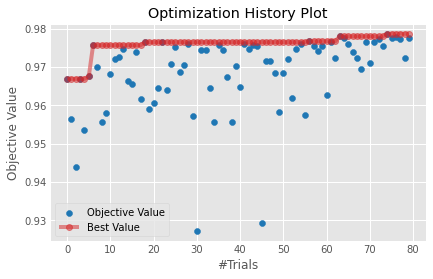

In [46]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

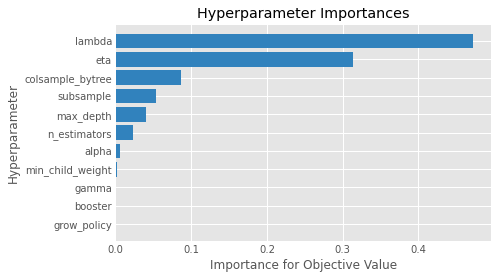

In [47]:
optuna.visualization.matplotlib.plot_param_importances(study)

## Define and train model given the best hyperparameters

In [48]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

In [49]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,805088.0,1410.656204,2215.639459,-100.0,148.0,723.0,1420.0,16000.0
sur_refl_b02_1,805088.0,2008.491541,2041.491274,-100.0,137.0,1978.0,2633.0,16000.0
sur_refl_b03_1,805088.0,1138.789577,2235.686010,-100.0,204.0,367.0,696.0,13347.0
sur_refl_b06_1,805088.0,1576.069502,1354.122924,-100.0,88.0,1528.0,2652.0,10993.0
sur_refl_b07_1,805088.0,439.915830,4339.861624,-28672.0,46.0,722.0,1748.0,7247.0
ndvi,805088.0,-300.777500,6820.032113,-32727.0,-3421.0,1256.0,4198.0,32679.0
b01_sur_refl_b03_1,805088.0,418.789388,4466.184900,-32727.0,-1420.0,2287.0,3663.0,32762.0
b01_sur_refl_b07_1,805088.0,253.083675,5042.557471,-32727.0,-3273.0,-1569.0,3592.0,32762.0
b02_ndvi,805088.0,-2848.003456,8340.329855,-32767.0,-9994.0,-3935.0,591.0,32767.0
b03_sur_refl_b04_1,805088.0,-1474.950198,2357.868198,-32727.0,-2927.0,-2234.0,48.0,32553.0


In [1]:
hyperparameters = best_trial_params

base_params = {"verbosity": 0,
               "objective": "binary:logistic",
               "tree_method": "hist",
               "n_jobs": -1}

hyperparameters.update(base_params)
print('Using these params:')
pprint(hyperparameters)

NameError: name 'best_trial_params' is not defined

In [14]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["error", "auc"]
hyperparameters = {'alpha': 0.00016460780631131285,
 'booster': 'dart',
 'colsample_bytree': 0.23719621881000702,
 'eta': 0.06246382190577308,
 'gamma': 0.0013198987967330343,
 'grow_policy': 'depthwise',
 'lambda': 5.542183143116679e-07,
 'max_depth': 9,
 'min_child_weight': 3,
 'n_estimators': 500,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'subsample': 0.23761009745083714,
 'tree_method': 'hist',
 'verbosity': 0}
classifier = xgb.XGBClassifier(**hyperparameters)

In [15]:
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=20)

[0]	validation_0-error:0.02933	validation_0-auc:0.99364	validation_1-error:0.03022	validation_1-auc:0.99321
[1]	validation_0-error:0.02822	validation_0-auc:0.99437	validation_1-error:0.02909	validation_1-auc:0.99413
[2]	validation_0-error:0.02728	validation_0-auc:0.99434	validation_1-error:0.02811	validation_1-auc:0.99416
[3]	validation_0-error:0.02667	validation_0-auc:0.99472	validation_1-error:0.02743	validation_1-auc:0.99460
[4]	validation_0-error:0.02661	validation_0-auc:0.99511	validation_1-error:0.02734	validation_1-auc:0.99500
[5]	validation_0-error:0.02623	validation_0-auc:0.99520	validation_1-error:0.02689	validation_1-auc:0.99508
[6]	validation_0-error:0.02607	validation_0-auc:0.99517	validation_1-error:0.02692	validation_1-auc:0.99504
[7]	validation_0-error:0.02594	validation_0-auc:0.99528	validation_1-error:0.02686	validation_1-auc:0.99515
[8]	validation_0-error:0.02587	validation_0-auc:0.99540	validation_1-error:0.02661	validation_1-auc:0.99522
[9]	validation_0-error:0.025

XGBClassifier(alpha=0.00016460780631131285, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.23719621881000702, eta=0.06246382190577308,
              gamma=0.0013198987967330343, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              lambda=5.542183143116679e-07, learning_rate=0.0624638237,
              max_delta_step=0, max_depth=9, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.000164607802,
              reg_lambda=5.54218275e-07, scale_pos_weight=1,
              subsample=0.23761009745083714, tree_method='hist',
              validate_parameters=1, verbosity=0)

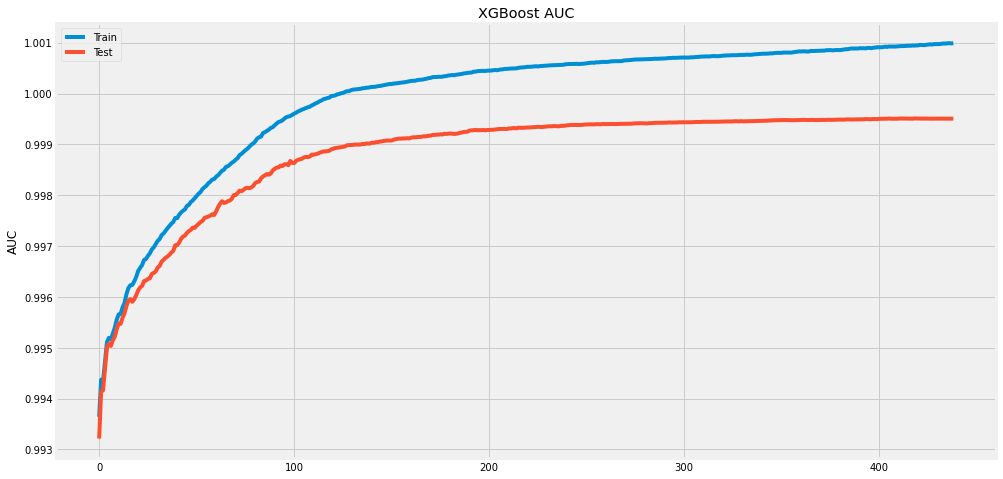

In [16]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

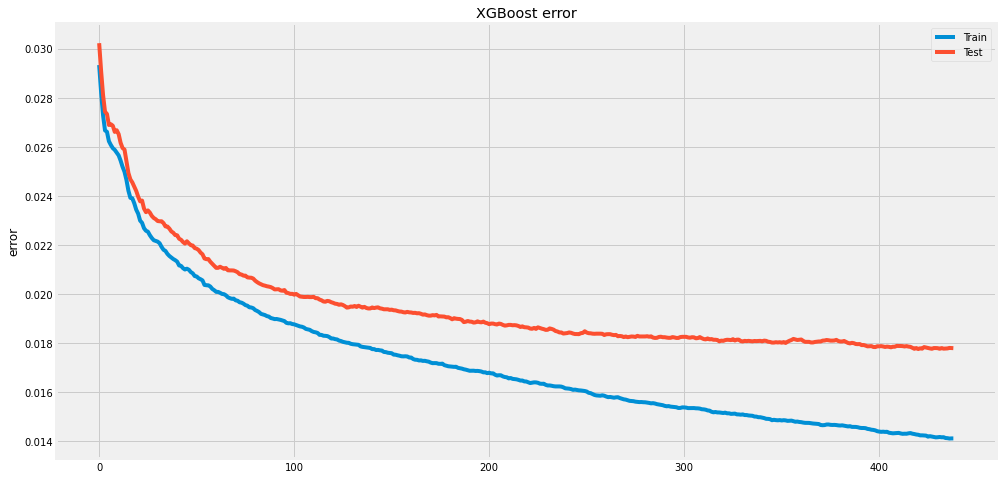

In [17]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [18]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.982

In [19]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [20]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [21]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
# From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp = confusion_matrix(y_test_int, test_predictions).ravel()
recall = (tp / (tp + fp))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print('TP: {:9} FN: {:9}'.format(tp, fn))
print('FP: {:9} TN: {:9}'.format(fp, tn))

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    114457
           1       0.98      0.98      0.98     86816

    accuracy                           0.98    201273
   macro avg       0.98      0.98      0.98    201273
weighted avg       0.98      0.98      0.98    201273

Test Recall
-------------------------------------------------------
0.9834587863581451
Confusion Matrix
-------------------------------------------------------
TP:     84664 FN:      2152
FP:      1424 TN:    113033


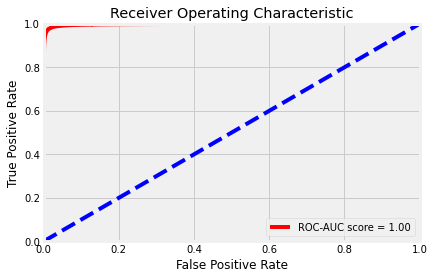

In [22]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Permutation importance

In [24]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

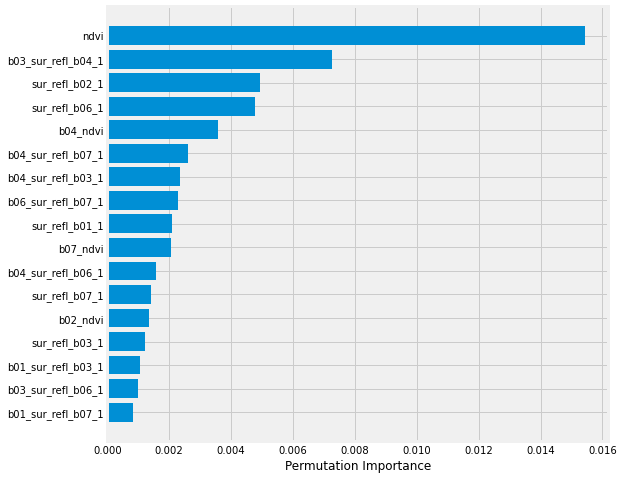

In [25]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

In [ ]:
X_test.columns[sorted_idx]

## Save the model for future use

In [23]:
model_save_path = 'mw_{}_{}_{}_{}_4.5.0_tuned_{}.sav'.format(TILE,
                                                      score,
                                                      hyperparameters['n_estimators'],
                                                      MODEL,
                                                      'gpu' if GPU else 'cpu',
                                                      datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.982_500_xgboost_4.5.0_tuned_gpu.sav
XGBClassifier(alpha=0.00016460780631131285, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.23719621881000702, eta=0.06246382190577308,
              gamma=0.0013198987967330343, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              lambda=5.542183143116679e-07, learning_rate=0.0624638237,
              max_delta_step=0, max_depth=9, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.000164607802,
              reg_lambda=5.54218275e-07, scale_pos_weight=1,
              subsample=0.23761009745083714, tree_method='hist',
              validate_parameters=1, verbosity=0)


['/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.982_500_xgboost_4.5.0_tuned_gpu.sav']

# Testing: Raster testing

In [60]:
TILE = 'h11v10'

In [61]:
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [62]:
vars_list_gq = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GQ.A2006201.h11v10.061.2020266164349-sur_refl_b01_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GQ.A2006201.h11v10.061.2020266164349-sur_refl_b02_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b03_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b04_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b05_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b06_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [63]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [64]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, len(index_names.keys()))
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    for band, combo in band_combo.items():
        print('{}({}) = {}({}) x {}({})'.format(band, 
                                                index_names[band], 
                                                combo[0], 
                                                index_names[combo[0]], 
                                                combo[1], 
                                                index_names[combo[1]]))
        b0 = img[:, index_names[combo[0]]]
        b1 = img[:, index_names[combo[1]]]
        img[:, index_names[band]] = ((b0 - b1) / (b0 + b1)) * 10000
    
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [65]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

b01_sur_refl_b02_1(10) = sur_refl_b01_1(0) x sur_refl_b02_1(1)
b01_sur_refl_b03_1(11) = sur_refl_b01_1(0) x sur_refl_b03_1(2)
b01_sur_refl_b04_1(12) = sur_refl_b01_1(0) x sur_refl_b04_1(3)
b01_sur_refl_b06_1(13) = sur_refl_b01_1(0) x sur_refl_b06_1(5)
b01_sur_refl_b07_1(14) = sur_refl_b01_1(0) x sur_refl_b07_1(6)
b01_ndvi(15) = sur_refl_b01_1(0) x ndvi(7)
b01_ndwi1(16) = sur_refl_b01_1(0) x ndwi1(8)
b01_ndwi2(17) = sur_refl_b01_1(0) x ndwi2(9)
b02_sur_refl_b01_1(18) = sur_refl_b02_1(1) x sur_refl_b01_1(0)
b02_sur_refl_b03_1(19) = sur_refl_b02_1(1) x sur_refl_b03_1(2)
b02_sur_refl_b04_1(20) = sur_refl_b02_1(1) x sur_refl_b04_1(3)
b02_sur_refl_b06_1(21) = sur_refl_b02_1(1) x sur_refl_b06_1(5)
b02_sur_refl_b07_1(22) = sur_refl_b02_1(1) x sur_refl_b07_1(6)
b02_ndvi(23) = sur_refl_b02_1(1) x ndvi(7)
b02_ndwi1(24) = sur_refl_b02_1(1) x ndwi1(8)
b02_ndwi2(25) = sur_refl_b02_1(1) x ndwi2(9)
b03_sur_refl_b01_1(26) = sur_refl_b03_1(2) x sur_refl_b01_1(0)
b03_sur_refl_b02_1(27) = sur_refl_b03_1(2

In [66]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=index_names.keys(), dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [ ]:
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster


In [ ]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [ ]:
df.describe().T

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [ ]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [ ]:
qa_list = [fn for fn in glob.glob(os.path.join(qaMaskPath, '{}/*A{}{:03}.{}*.tif'.format(TILE, YEAR, DAY, TILE)))]
try:
    qa_mask = qa_list[0]
    print(qa_mask)
    ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
    qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
except Exception:
    path = os.path.join(qaMaskPath, '{}/*A{}{:03}.{}*.tif'.format(TILE, YEAR, DAY, TILE))
    print('Could not find QA mask at {}'.format(path))
    qaMaskMatrix = np.zeros((4800, 4800))

In [ ]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

In [ ]:
waterMaskMatrix

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [ ]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Metrics on test raster

In [ ]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [ ]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

### Count num of occurences for each class with the water mask

In [ ]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

### Model metrics on raster data

In [ ]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

## Output predicted raster to GeoTiff

In [ ]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

In [ ]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [ ]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [ ]:
mask_3857 = reproject_to_3857(outPath)
probW_3857 = reproject_to_3857(outPathProba)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask)

mask_d = get_bounds(mask_3857)
probw_d = get_bounds(probW_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
probw_b1 = open_and_get_band(probW_3857, 1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(probW_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
probw_rgb = np.dstack((zeros, zeros, probw_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

In [ ]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [ ]:
from folium import plugins

In [ ]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(probw_rgb, probw_d, '{}-{}-{} model proba water'.format(YEAR, DAY, TILE), opacity=0.35, show=False))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())

# Model Explainability

In [ ]:
maskToShow = np.where(maskedResult==-9999, -1, maskedResult)
waterMaskToShow = np.where(waterMasked==-9999, -1, waterMasked)

In [ ]:
print((1020, 1250), (3000, 3250))
y = (3000, 3000+250)
x = (1020, 1020+230)
x, y

In [ ]:
width = x[1] - x[0]
height = y[1] - y[0]

In [ ]:
from matplotlib.patches import Rectangle
import shap

shap.initjs()

In [ ]:
plt.figure(figsize=(20, 20))
plt.matshow(maskToShow, fignum=1)
plt.gca().add_patch(Rectangle((x[0],y[0]),width,height,
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
plt.colorbar()

In [ ]:
plt.figure(figsize=(20, 20))
plt.matshow(waterMaskToShow, fignum=1)
plt.gca().add_patch(Rectangle((x[0],y[0]),width,height,
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
plt.colorbar()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

ax1, ax2 = axes

im1 = ax1.matshow(maskToShow[y[0]:y[1], x[0]:x[1]])
im2 = ax2.matshow(waterMaskToShow[y[0]:y[1], x[0]:x[1]])

ax1.set_title('Predicted Mask')
ax2.set_title('MOD44W Mask')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [ ]:
def readRaster(vars_list, x, y, colsToDrop=None):
    min_right, max_right = x
    min_bottom, max_bottom = y
    cols = max_bottom - min_bottom
    rows = max_right - min_right
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (cols, rows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, :, b] = dd.GetRasterBand(b+1).ReadAsArray()[min_bottom:max_bottom, min_right:max_right].astype(np.int16)
    dd = None
    img[:, :, len(vars_list)] = ((img[:,:,1] - img[:,:,0]) / (img[:,:,1] + img[:,:,0])) * 10000
    img[:, :, len(vars_list)+1] = ((img[:,:,1] - img[:,:,5]) / (img[:,:,1] + img[:,:,5])) * 10000
    img[:, :, len(vars_list)+2] = ((img[:,:,1] - img[:,:,6]) / (img[:,:,1] + img[:,:,6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

def plot_comparison(mask, band, img):
    fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

    ax1, ax2 = axes

    im1 = ax1.matshow(img[:, :, band-1])
    im2 = ax2.matshow(mask)
    band_name = band
    if band >=8 :
        if band == 8:
            band_name = 'ndvi'
        elif band == 9:
            band_name = 'ndwi1'
        elif band == 10:
            band_name = 'ndwi2'
            
    ax1.set_title('Tile: {} Day: {} Year: {} Band: {}'.format(TILE, DAY, YEAR, band_name))
    ax2.set_title('Tile: {} Day: {} Year: {} Predicted Water Mask'.format(TILE, DAY, YEAR))
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)
    
def readRasterToArray(vars_list, x, y, colsToDrop=None):
    min_right, max_right = x
    min_bottom, max_bottom = y
    cols = max_bottom - min_bottom
    rows = max_right - min_right
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (cols*rows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray()[min_bottom:max_bottom, min_right:max_right].astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    df = pd.DataFrame(img, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    return df

In [ ]:
img = readRaster(vars_list, x, y, colsToDrop=colsToDrop)

In [ ]:
mask = maskToShow[y[0]:y[1], x[0]:x[1]]
plot_comparison(mask=mask,
                band=1,
                img=img)

In [ ]:
X_expl = readRasterToArray(vars_list, x, y, colsToDrop)
X_expl

In [ ]:
bg_set = X_train.sample(n=500, random_state=42)
bg_set = bg_set.reset_index()
bg_set = bg_set.drop(columns=['index'])

In [ ]:
explainer = shap.explainers.Tree(model=classifier, data=bg_set, model_output='predict_proba')
explainer

In [ ]:
shap_test = explainer(X_expl)
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test:\n{shap_test[0]}")

In [ ]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.2f}")

In [ ]:
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
                       columns=shap_test.feature_names, 
                       index=X_expl.index)
shap_df

In [ ]:
shap.plots.bar(shap_test[:,:,1])

In [ ]:
columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index

fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h',ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values")

In [ ]:
shap.summary_plot(shap_test[:,:,1], plot_size=(17, 10), show=False)
plt.gcf().axes[-1].set_aspect(10)
plt.gcf().axes[-1].set_box_aspect(10)

## Examining individual cases of false positives

In [ ]:
X_test = X_expl

In [ ]:
test_1 = X_test[X_test['sur_refl_b01_1'] == 981]
test_1 = test_1[test_1['sur_refl_b04_1'] == 931]

test_2 = X_test[X_test['sur_refl_b01_1'] == 1395]
test_2 = test_2[test_2['sur_refl_b04_1'] == 931]

test_3 = X_test[X_test['sur_refl_b01_1'] == 1197]
test_3 = test_3[test_3['sur_refl_b04_1'] == 890]

test_4 = X_test[X_test['sur_refl_b01_1'] == 754]
test_4 = test_4[test_4['sur_refl_b04_1'] == 325]

test_5 = X_test[X_test['sur_refl_b01_1'] == 1025]
test_5 = test_5[test_5['sur_refl_b04_1'] == 780]

test_6 = X_test[X_test['sur_refl_b01_1'] == 552]
test_6 = test_6[test_6['sur_refl_b04_1'] == 459]

test_7 = X_test[X_test['sur_refl_b01_1'] == 1120]
test_7 = test_7[test_7['sur_refl_b04_1'] == 780]

In [ ]:
test_1

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_test[:, :, 1].values[test_1.index[0]], feature_names=shap_test.feature_names)

In [ ]:
test_2

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_test[:, :, 1].values[test_2.index[0]], feature_names=shap_test.feature_names)

In [ ]:
test_3

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_test[:, :, 1].values[test_3.index[0]], feature_names=shap_test.feature_names)

In [ ]:
test_4

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_test[:, :, 1].values[test_4.index[0]], feature_names=shap_test.feature_names)

In [ ]:
test_5

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_test[:, :, 1].values[test_5.index[0]], feature_names=shap_test.feature_names)

In [ ]:
test_6

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_test[:, :, 1].values[test_6.index[0]], feature_names=shap_test.feature_names)